In [3]:
import torch
import numpy as np
import config as cfg
from tqdm import tqdm
import torch.nn as nn
from datamanager import *
from models import *
import sklearn.metrics as metrics
from torch.utils.data import DataLoader

In [4]:
PATH = cfg.DATAPATH['femnist']
file_dict = get_files(PATH)

In [5]:
TEST_DM = DataManager(file_dict['test'], is_train=False, is_flat=False)

In [6]:
data       = FEMNIST(TEST_DM.global_test_data)
dataloader = DataLoader(data, batch_size=256, shuffle=False, drop_last=False)

In [40]:
T = 0.1
saved_model = CNN()
saved_model.load_state_dict(torch.load(f'./checkpoints/cnn_femnist_{T}/_100.pth'))

<All keys matched successfully>

In [41]:
saved_model.eval()
saved_model.to(cfg.DEVICE)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=62, bias=True)
)

In [42]:
result_pred, result_anno = [], []
preds = []
for idx, batch in enumerate(tqdm(dataloader)):
    with torch.no_grad():
        X, Y = batch
        X, Y = X.to(cfg.DEVICE), Y.to(cfg.DEVICE)
        pred = saved_model(X)/T
        preds.append(pred.to('cpu').detach())
        pred_np  = pred.to('cpu').detach().numpy()
        pred_np  = np.argmax(pred_np, axis=1).squeeze()
        Y_np     = Y.to('cpu').detach().numpy().reshape(-1, 1).squeeze()
        result_pred = np.hstack((result_pred, pred_np))
        result_anno = np.hstack((result_anno, Y_np))
    acc = metrics.accuracy_score(y_true=result_anno, y_pred=result_pred)

100%|██████████| 66/66 [00:00<00:00, 130.30it/s]


In [43]:
print(acc)

0.8061634390550992


In [44]:
preds = np.vstack(preds)
preds = torch.from_numpy(preds)

In [45]:
softmax = nn.Softmax(dim=1)
probs = softmax(preds)

In [46]:
def get_calibration(probs, anno):
    """
    probs: 각 sample에 대한 probability 정보 ()
    anno: 각 sample의 ground truth 정보
    
    """
    assert len(probs) == len(anno)
    calib_dict = {True:{f'{0.1*i:.1f}':0 for i in range(11)},
                  False:{f'{0.1*i:.1f}':0 for i in range(11)}}
    for idx, prob in enumerate(probs):
        flag = bool(np.argmax(prob)==anno[idx])
        calib_dict[flag][f'{max(prob):.1f}'] += 1
    
    keys = list(calib_dict[True].keys())
    keys.sort()
    
    calibs = []
    
    for key in keys:
        calibs.append(calib_dict[True][key]/(calib_dict[True][key]+calib_dict[False][key]+1e-5))
    return calibs, keys

calibs, keys = get_calibration(probs, result_anno)

In [47]:
avg_prob = torch.mean(torch.max(probs, dim=1).values)
print(f"Average Prob:{avg_prob:0.4f} Average Acc:{acc:0.4f}")

Average Prob:0.8515 Average Acc:0.8062


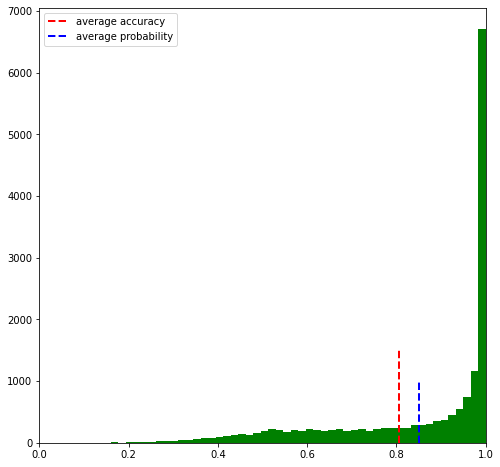

In [48]:
probs_np = np.array(torch.max(probs, dim=1).values)
plt.figure(figsize=(8,8))
plt.hist(probs_np,bins=50, color='green')
plt.vlines(x=acc, ymin=0, ymax=1500, color='red', linestyle='--', linewidth=2, label='average accuracy')
plt.vlines(x=avg_prob, ymin=0, ymax=1000, color='blue', linestyle='--', linewidth=2, label='average probability')
plt.legend()
plt.xlim([0,1])
plt.show()

In [49]:
calibs

[0.0,
 0.0,
 0.2244897501041326,
 0.3252427026581212,
 0.38312828852147124,
 0.4615384571553803,
 0.5456831471443157,
 0.5827338082914963,
 0.6929884227842857,
 0.813374122319169,
 0.9772119509624324]

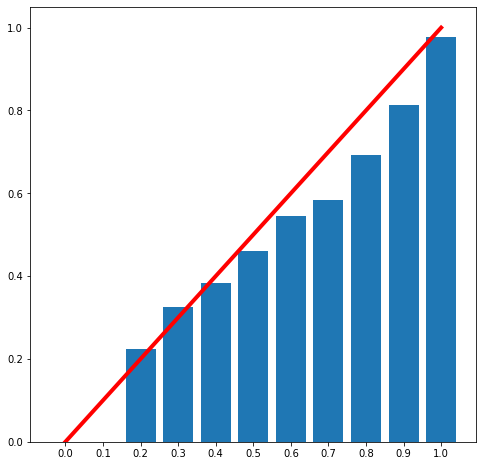

In [50]:
plt.figure(figsize=(8,8))
plt.plot([f'{0.1*i:.1f}' for i in range(0, 11)], [0.1*i for i in range(0, 11)], color='r', linewidth=4)
plt.bar(x=[f'{0.1*i:.1f}' for i in range(0, 11)], height=calibs)
plt.show()

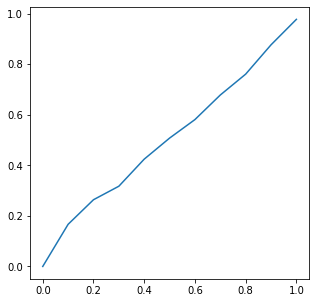

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0.1*i for i in range(0, 11)], calibs)
plt.show()

In [52]:
p = pred[0].detach().cpu()
p_ = nn.Softmax(dim=0)(p/0.1).numpy()
print(max(p_)-min(p_))

0.99998665


In [53]:
print(max(probs[0])-min(probs[0]))

tensor(0.9667)


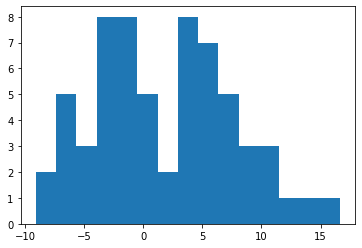

In [23]:
plt.hist(np.array(p), bins=15)
plt.show()

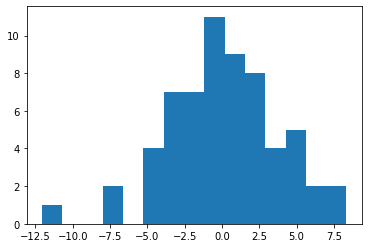

In [39]:
plt.hist(np.array(p), bins=15)
plt.show()

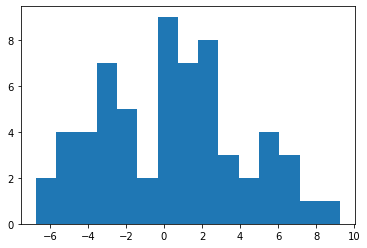

In [54]:
plt.hist(np.array(p), bins=15)
plt.show()

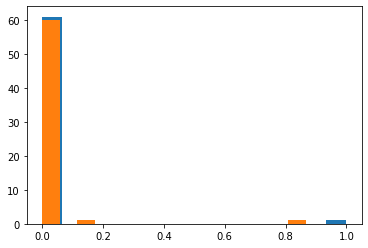

In [22]:
plt.hist(np.array(p_), bins=15)
plt.hist(nn.Softmax(dim=0)(p).numpy(), bins=15)
plt.show()

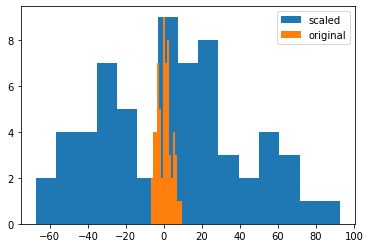

In [57]:
plt.hist(np.array(p)/0.1, bins=15, label='scaled')
plt.hist(np.array(p), bins=15, label='original')
plt.legend()
plt.show()